Requirements to run this:

* matplotlib
* numpy
* pandas
* seaborn
* patchworklib
    * `pip install patchworklib` (makes some bits of seaborn less awkward)
    * https://github.com/ponnhide/patchworklib


In [37]:



import numpy as np
import pandas as pd
from pandas import DataFrame
from typing import Iterable, Union, Dict, List, Tuple, Optional, Any
import inspect
import doctest

import uuid

import patchworklib as pw
import seaborn as sns
import matplotlib.pyplot as plt


from collections.abc import Hashable

In [25]:
%matplotlib inline

## Step 1: Loading the data

Before I can start analysing the data, I need to actually load it.
These functions (below) are intended to make that job a bit easier.

### 1.1: Some utility functions, to allow me to load the data in a way that makes some sense


In [26]:
def npz_to_dict(
        npz_filename: str,
        **kwargs
) -> Dict[str, np.ndarray]:
    """
    Puts the given NPZ file into a dictionary of {table name, ndarray}.
    :param npz_filename: the filename of the NPZ file that we want to put into a dictionary.
    :param kwargs: kwargs from https://numpy.org/doc/stable/reference/generated/numpy.load.html#numpy.load.
    DO NOT INCLUDE A 'mmap_mode' KWARG!!!
    :return: The data from the given npz file in a dictionary.
    """
    data_dict: Dict[str, np.ndarray] = {}
    if kwargs is None:
        kwargs = {}
    with np.load(npz_filename, mmap_mode="r",**kwargs) as npz:
        for f in npz.files:
            data_dict[f] = npz[f]
    return data_dict


def turn_01_columns_into_int(
        dataframe_to_edit: DataFrame,
) -> DataFrame:
    """
    Finds all of the columns that just contain values of 0 and 1,
    and converts all of those columns to ints.
    MODIFIES THE GIVEN DATAFRAME!
    :param dataframe_to_edit: the dataframe that is being edited
    :return: The modified dataframe.
    DOES NOT COPY THE GIVEN ORIGINAL DATAFRAME.

    >>> before: DataFrame = DataFrame.from_dict(data={"int01":[0,1,1,0],"flt01":[0.0, 1.0, 0.0, 1.0], "intNo": [-1,0,1,2], "fltNo":[-1.0, 0.0, 1.0, 2.0], "intNan": [0,1,None,0], "fltNan":[0.0,1.0,None,0.0]})
    >>> before_types = before.dtypes.values
    >>> after: DataFrame = turn_01_columns_into_int(before.copy())
    >>> after_types = after.dtypes.values
    >>> print(after_types[0])
    uint8
    >>> print(after_types[1])
    uint8
    >>> print(f"{before_types[2] == after_types[2]} {before_types[3] == after_types[3]} {before_types[4] == after_types[4]} {before_types[5] == after_types[5]}")
    True True True True
    """
    for c in dataframe_to_edit.columns:
        if dataframe_to_edit[c].dtype == np.uint8:
            continue
        if dataframe_to_edit[c].isin([0,1]).all():
            dataframe_to_edit[c] = dataframe_to_edit[c].astype(np.uint8)
    return dataframe_to_edit

if __name__ == "__main__":
    doctest.run_docstring_examples(turn_01_columns_into_int, globals())

def x_to_dataframe(
        x_data: np.ndarray,
        row_major = True,
        x_prefix: str = "x_"
) -> DataFrame:
    """
    Converts the 'x' ndarray into a pandas dataframe.
    :param x_data: the ndarray containing all of the data
    :param row_major: is this ndarray held in row-major order? [[item a data], [item b data], ... ]
    :param x_prefix: prefix to put on the names of all of the x columns
    :return: a dataframe holding the given x data.
    """
    if row_major:
        x_data: np.ndarray = x_data.T
    x_df: DataFrame = pd.DataFrame.from_dict({f"{x_prefix}{i}": x_data[i] for i in range(x_data.shape[0])})

    return turn_01_columns_into_int(x_df)



def add_everything_but_x_to_copy_of_dataframe(
        original_df: DataFrame,
        the_data_dict: Dict[str, np.ndarray],
        dont_add: Union[str, Iterable[str]]=frozenset('x')
) -> DataFrame:
    """
    Adds everything in the npz file apart from the given 'dont_add'
    tables to the dataframe.
    Assumes that these other tables have the same shape of (whatever, 1).
    :param original_df: the original dataframe that shall be copied and have stuff added to it.
    :param the_data_dict: The data file with the data to be added to the DataFrame
    :param dont_add: the identifier(s) of the columns that must not be added to the DataFrame.
    :return: a copy of the original dataframe, with the data from every table BESIDES the 'dont add' tables
    from the given file added to it.
    """

    the_df = original_df.copy()
    if dont_add in the_data_dict.keys():
        dont_add = [dont_add]
    for k, v in the_data_dict.items():
        if k in dont_add:
            continue
        the_df[k] = turn_01_columns_into_int(DataFrame(v))
    return the_df

#### 1.1.2: And some utility functions for producing graphs based on the datasets

In [42]:
def bin_finder(n: int, default_bins: int) -> int:

    if n <= default_bins:
        return n

    biggest_possible = np.floor(np.sqrt(n)).astype(int)

    potentials = np.arange(biggest_possible, stop=0, step=-1)
    divisor_indices = np.flatnonzero(n % potentials==0)

    print(potentials[divisor_indices])
    if divisor_indices.size > 0:
        print(f"{n} -> {n // potentials[divisor_indices[0]]}")
        return min(default_bins, n // potentials[divisor_indices[0]])
    return default_bins


def squareish_w_h(div_this: int) -> Tuple[int, int]:
    """
    Attempts to make a shape not entirely unlike a square
    :param div_this: int to divide
    :return: square-ish w/h
    """
    if np.sqrt(div_this) % 1 == 0:
        res = np.floor(np.sqrt(div_this))
        return res, res
    elif div_this & 1 == 0: # odd number
        return fallback_w_h(div_this)
    else:
        # if even, we work out which binary rectangle works best basically
        a: int = 1
        b: int = div_this
        while b > a and b & 1 == 0:
            b //= 2
            a *= 2
        if max(a, b) > min(a, b) * 2:
            return fallback_w_h(div_this)
        else:
            return tuple(*sorted((a, b), reverse=True))

def fallback_w_h(div_this: int) -> Tuple[int, int]:
    """
    Attempts to make a shape not entirely unlike a square
    :param div_this: int to divide
    :return: square-ish w/h
    """
    h = np.floor(np.sqrt(div_this))
    # get something relatively close to the square
    w = div_this//h

    i_w = w < h
    if w * h < div_this:
        if i_w:
            w += 1
        else:
            h += 1
        i_w = not i_w
    return w, h

def jointplot_maker(df: DataFrame, xlabel: str, ylabel: str, tlabel: str, wh: int = 5, debug: bool = False):

    pw.param["margin"] = 0.1

    ax_x_label: str = xlabel
    if debug:
        ax_x_label = f"{uuid.uuid4()}"

    ax1 = pw.Brick(f"{ax_x_label}_ax1",figsize=(wh, wh/4))
    sns.histplot(data=df, x=xlabel, hue=tlabel, kde=True, ax=ax1)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    ax2 = pw.Brick(f"{ax_x_label}_ax2",figsize=(wh/4, wh))
    sns.histplot(data=df, y=ylabel, hue=tlabel, kde=True, ax=ax2)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)

    ax3 = pw.Brick(f"{ax_x_label}_ax3",figsize=(3*wh/4, 3*wh/4))
    #sns.kdeplot(data=df, x=xlabel, y=ylabel, hue=tlabel, ax=ax3, alpha=.5)
    sns.scatterplot(data=df, x=xlabel, y=ylabel, hue=tlabel, ax=ax3, alpha=.5)
    # TODO: overlay kernel density over scatterplot?

    ax1.set_xlim(ax3.get_xlim())
    ax1.set_xticks([])
    ax1.set_xlabel("")

    ax2.set_ylim(ax3.get_ylim())
    ax2.set_yticks([])
    ax2.set_ylabel("")

    ax13 = ax1/ax3
    ax132 = ax13[f"{ax_x_label}_ax3"]|ax2

    ax132.case.set_title(f"Distribution for {xlabel}")
    return ax132


def viz2(df: DataFrame, xlabels: List[Any], ylabel: Any, tlabel: Any, fig_subject: str) -> plt.Figure:
    """
    Produces a series of graphs based on the given data
    :param df: the dataframe
    :param xlabels: column names for T
    :param ylabel: column name for Y
    :param tlabel: column name for T
    :param fig_subject: words for what the source of the data being shown is
    :return: a figure showing the input data as a series of histograms
    """

    y_series: pd.Series = df[ylabel]
    t_series: pd.Series = df[tlabel]

    Y: np.ndarray = y_series.values
    T: np.ndarray = t_series.values

    bins: int = bin_finder(Y.size, 20)

    if fig_subject is None:
        fig_subject = ""
    else:
        fig_subject = f" {fig_subject}"

    print(xlabels)

    x_count: int = len(xlabels)

    w, h = squareish_w_h(x_count)

    #sns.FacetGrid = sns.FacetGrid(data=df, col="")

    #fig: plt.Figure = plt.Figure(
    #    figsize=(w*3, h*3)
    #)

    #axes: Tuple[plt.Axes] = fig.subplots(
    #    nrows=h, ncols=w, squeeze=True
    #)

    figrows = []

    current_row = -1

    for i in range(x_count):

        this_plot = jointplot_maker(
            df,
            xlabels[i],
            ylabel,
            tlabel
        )



        if i % w == 0:
            figrows.append(this_plot)
            current_row += 1
        else:
            figrows[current_row] |= this_plot

    the_fig = figrows[0]
    for i in range(1, len(figrows)):
        the_fig /= figrows[i]

    the_figure: plt.Figure = figrows.savefig()
    the_figure.suptitle(f"Joint graphs for {fig_subject}")
    return the_figure





def visualizer(df: DataFrame, xlabels: List[Any], ylabel: Any, tlabel: Any, fig_subject: str) -> plt.Figure:
    """
    Produces a series of graphs based on the given data
    :param df: the dataframe
    :param xlabels: column names for T
    :param ylabel: column name for Y
    :param tlabel: column name for T
    :param fig_subject: words for what the source of the data being shown is
    :return: a figure showing the input data as a series of histograms
    """

    y_series: pd.Series = df[ylabel]
    t_series: pd.Series = df[tlabel]

    Y: np.ndarray = y_series.values
    T: np.ndarray = t_series.values

    bins: int = bin_finder(Y.size, 20)



    if fig_subject is None:
        fig_subject = ""
    else:
        fig_subject = f" {fig_subject}"

    print(xlabels)

    y_t_str: Tuple[str, str] = ("Y", "T")
    y_t_np: Tuple[np.ndarray, np.ndarray] = (Y, T)
    y_t_bins: Tuple[int, int] = (
        min(bins,np.unique(Y).shape[0]),
        min(bins,np.unique(T).shape[0])
    )
    "This will be useful later on."

    y_treated: np.ndarray = Y[np.argwhere(T==1)]
    y_untreated: np.ndarray = Y[np.argwhere(T==0)]

    col_count: int = len(xlabels)
    fig: plt.Figure = plt.figure(figsize=(24, 1+(4*col_count)))
    subfigs: tuple[plt.Figure, ...] = fig.subfigures(nrows=col_count, ncols=1)
    for i in range(col_count):

        sfig: plt.Figure = subfigs[i]
        label: str = xlabels[i]
        x_data: np.ndarray = df[label].to_numpy()


        this_bins = bin_finder(df[label].nunique(), 20)

        sfig.suptitle(f"Data for {label}")
        sfigs: tuple[plt.Figure, plt.Figure] = sfig.subfigures(nrows=1,ncols=3,width_ratios=[1,1,3])

        hist1: plt.Figure = sfigs[0]
        hist1.suptitle(f"{label} quantities")
        hist_x_plt: plt.Axes = hist1.add_subplot()
        sns.histplot(data = x_data, stat="frequency", bins = this_bins, kde=True, ax=hist_x_plt)
        hist_x_plt.set_xlabel(f"{label}")
        hist_x_plt.set_ylabel("quantity")

        hist2: plt.Figure = sfigs[1]

        hist2_plt: plt.Axes = hist2.add_subplot()
        sns.kdeplot(
                data=df[[label, ylabel, tlabel]], x=label,y=ylabel,
                ax=hist2_plt, legend=True, hue=tlabel, fill=True,
                alpha=.5, #kind="kde"
        )
        hist2_plt.set_title(f"{label} and Y for treatment/control")
        hist2_plt.set_xlabel(f"{label}")
        hist2_plt.set_ylabel(f"outcome given {label}")

        scatters: plt.Figure = sfigs[2]

        x_treated: np.ndarray = x_data[np.argwhere(T==1)]
        x_untreated: np.ndarray = x_data[np.argwhere(T==0)]

        #hists.suptitle(f"More histograms for {label}")
        #hist_axes: Tuple[plt.Axes, plt.Axes, plt.Axes] = hists.subplots(nrows=1, ncols=2, sharex="all")


        scatters.suptitle(f"Scatter graphs for {label}")
        ax0, ax1, ax2 = scatters.subplots(nrows=1, ncols=3, sharex="all",sharey="all")
        ax0.set_xlabel(f"{label}")
        ax0.set_ylabel(f"Outcome from {label}")
        ax0.set_title("both")
        ax1.set_title("treated only")
        ax2.set_title("control only")
        ax0.scatter(x_treated, y_treated, c = "g", label = "Treated")
        ax1.scatter(x_treated, y_treated, c = "g")
        ax0.scatter(x_untreated, y_untreated, c = "r", label = "Control")
        ax2.scatter(x_untreated, y_untreated, c = "r")
        ax0.legend()

    fig.suptitle(f"X, Y, T visualizations all dimensions of X in{fig_subject}")
    return fig






### 1.2: Loading the IHPD dataset

Firstly, I need to load the dataset, and see what data is present.

In [28]:
ihdp_dict: Dict[str, np.ndarray] = npz_to_dict("ihdp.npz", allow_pickle = False)


for k,v in ihdp_dict.items():
    print(f"{k}: {v.shape}")

x: (747, 25)
t: (747, 1)
yf: (747, 1)
ycf: (747, 1)
ite: (747, 1)


#### 1.2.1: Extracting the 'x' column, and moving it to a dataframe

It looks like the 'x' data is a table of 747 rows and 25 columns.
This, by itself, is a bit difficult to digest, so I shall move that
into a dataframe, making it a bit easier to analyse (for now at least).

The following two code cells are just outputting an overview of the 'x'
data.

In [29]:
ihdp_df_x: DataFrame = x_to_dataframe(ihdp_dict['x'])
"""Dataframe holding the 'x' data for the IHDP dataset"""

ihdp_df_x.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1,0,1,0,...,1,1,1,1,0,0,0,0,0,0
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1,0,1,1,...,1,1,1,0,0,0,0,0,0,1
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1,0,0,0,...,1,0,1,0,1,0,0,0,0,0
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0,1,1,0,...,1,0,1,1,0,0,0,0,0,0


In [30]:
print(ihdp_df_x.info())



ihdp_df_x.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_0     747 non-null    float64
 1   x_1     747 non-null    float64
 2   x_2     747 non-null    float64
 3   x_3     747 non-null    float64
 4   x_4     747 non-null    float64
 5   x_5     747 non-null    float64
 6   x_6     747 non-null    uint8  
 7   x_7     747 non-null    uint8  
 8   x_8     747 non-null    uint8  
 9   x_9     747 non-null    uint8  
 10  x_10    747 non-null    uint8  
 11  x_11    747 non-null    uint8  
 12  x_12    747 non-null    uint8  
 13  x_13    747 non-null    uint8  
 14  x_14    747 non-null    uint8  
 15  x_15    747 non-null    uint8  
 16  x_16    747 non-null    uint8  
 17  x_17    747 non-null    uint8  
 18  x_18    747 non-null    uint8  
 19  x_19    747 non-null    uint8  
 20  x_20    747 non-null    uint8  
 21  x_21    747 non-null    uint8  
 22  x_

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24
count,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,747.000000,747.000000,747.000000,747.000000,...,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,3.448082e-17,4.755975e-18,-2.377988e-17,-5.612051e-16,4.042579e-17,-7.633341e-16,0.514056,0.093708,0.520750,0.364123,...,0.959839,0.594378,0.963855,0.135207,0.135207,0.156627,0.081660,0.073628,0.128514,0.157965
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.500137,0.291618,0.499904,0.481506,...,0.196467,0.491341,0.186775,0.342174,0.342174,0.363692,0.274029,0.261339,0.334886,0.364953
min,-2.731287e+00,-3.800823e+00,-1.850350e+00,-8.796060e-01,-5.130428e+00,-1.851480e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.669461e-01,-6.027100e-01,-7.332610e-01,-8.796060e-01,-5.666720e-01,-8.577868e-01,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.652752e-01,1.968181e-01,-3.608980e-01,1.617025e-01,1.210172e-01,-2.970882e-02,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.137593e-01,5.965822e-01,7.561910e-01,1.617025e-01,6.836721e-01,6.327536e-01,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.505476e+00,2.595403e+00,2.990369e+00,2.244320e+00,2.371637e+00,2.951372e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
print(ihdp_df_x.nunique())

print("\nThe actual value counts for x_3")
print(ihdp_df_x["x_3"].value_counts())

x_0     214
x_1      46
x_2      14
x_3       4
x_4      87
x_5      30
x_6       2
x_7       2
x_8       2
x_9       2
x_10      2
x_11      2
x_12      2
x_13      2
x_14      2
x_15      2
x_16      2
x_17      2
x_18      2
x_19      2
x_20      2
x_21      2
x_22      2
x_23      2
x_24      2
dtype: int64

The actual value counts for x_3
-0.879606    346
 0.161703    236
 1.203011    100
 2.244320     65
Name: x_3, dtype: int64


Looking at `x_3`, and how all of the values in it are one of four distinct values,
 all of which are painfully close to being int values, I **really** want to just
 convert them into raw ints, which would be rather trivial to do,
 as follows (converting -0.879606 to 0, 0.161703 to 1, 1.203011 to 2,  2.244320 to 3, etc):

```python
import pandas as pd
import numpy as np
def x3_to_int(df: pd.DataFrame) -> pd.DataFrame:
    x3 = df["x_3"]
    x3_vals = [*x3.value_counts().keys()]
    x3_vals.sort()
    x3_diff = x3_vals[2] - x3_vals[1]
    x3 += x3_diff
    x3 /= x3_diff
    df["x_3"] = x3.astype(np.int8)
    return df
```

However, I will refrain from doing this. This is because I don't actually know what
the data in `x_3` is supposed to be. If I knew, with certainty, that `x_3`
would only ever be one of those for values (or, failing that, would always
be a value from a continuous range of values with a consistent
gap of `1.041308` between each value), I would be applying that bit of
scaling to `x_3`. But, as mentioned earlier, I don't. So I can't. Which is a shame.



#### 1.2.2: Extracting the rest of the IHDP dataset, before adding it to a dataframe

I shall copy the X data into a new dataframe (ensuring that I retain a backup copy of the dataframe holding
just the X data), and add the rest of the IHDP data to that new dataframe,
meaning that I'll be able to get a full overview of IHDP.


In [32]:
ihdp_df: DataFrame = add_everything_but_x_to_copy_of_dataframe(
    ihdp_df_x.copy(),
    ihdp_dict,
    "x"
)
"""Dataframe holding the entirety of the IHDP dataset"""

ihdp_df.head()


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_19,x_20,x_21,x_22,x_23,x_24,t,yf,ycf,ite
0,1.397395,0.996346,-1.105624,-0.879606,0.308569,-1.023402,1,0,0,0,...,0,0,0,0,0,1,1,4.771232,-0.298509,4.657928
1,0.269033,0.196818,0.383828,0.161703,-0.629189,1.460832,1,0,1,0,...,0,0,0,0,0,0,0,2.956273,5.783770,3.428604
2,1.051537,1.795874,-1.105624,0.161703,-0.629189,0.963985,1,0,1,1,...,0,0,0,0,0,1,0,4.164164,7.055789,3.658195
3,0.662446,0.196818,-0.733261,-0.879606,0.371086,-0.692171,1,0,0,0,...,1,0,0,0,0,0,1,6.172307,1.379697,4.585505
4,0.856992,1.795874,0.011465,-0.879606,0.558638,0.301522,0,1,1,0,...,0,0,0,0,0,0,1,7.834469,2.747986,4.265591


In [33]:
print("info about the full dataset")
print(ihdp_df.info())

print("\ntreatment info for the full dataset")
print(ihdp_df["t"].value_counts())

print("\ndescribing the dataset")
ihdp_df.describe()

info about the full dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_0     747 non-null    float64
 1   x_1     747 non-null    float64
 2   x_2     747 non-null    float64
 3   x_3     747 non-null    float64
 4   x_4     747 non-null    float64
 5   x_5     747 non-null    float64
 6   x_6     747 non-null    uint8  
 7   x_7     747 non-null    uint8  
 8   x_8     747 non-null    uint8  
 9   x_9     747 non-null    uint8  
 10  x_10    747 non-null    uint8  
 11  x_11    747 non-null    uint8  
 12  x_12    747 non-null    uint8  
 13  x_13    747 non-null    uint8  
 14  x_14    747 non-null    uint8  
 15  x_15    747 non-null    uint8  
 16  x_16    747 non-null    uint8  
 17  x_17    747 non-null    uint8  
 18  x_18    747 non-null    uint8  
 19  x_19    747 non-null    uint8  
 20  x_20    747 non-null    uint8  
 21  x_21    747

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_19,x_20,x_21,x_22,x_23,x_24,t,yf,ycf,ite
count,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,7.470000e+02,747.000000,747.000000,747.000000,747.000000,...,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000,747.000000
mean,3.448082e-17,4.755975e-18,-2.377988e-17,-5.612051e-16,4.042579e-17,-7.633341e-16,0.514056,0.093708,0.520750,0.364123,...,0.135207,0.156627,0.081660,0.073628,0.128514,0.157965,0.186078,3.159538,5.696107,4.016067
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.500137,0.291618,0.499904,0.481506,...,0.342174,0.363692,0.274029,0.261339,0.334886,0.364953,0.389430,2.179956,1.980121,0.859736
min,-2.731287e+00,-3.800823e+00,-1.850350e+00,-8.796060e-01,-5.130428e+00,-1.851480e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.543902,-1.037628,-1.866989
25%,-6.669461e-01,-6.027100e-01,-7.332610e-01,-8.796060e-01,-5.666720e-01,-8.577868e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.626779,5.053598,3.775936
50%,1.652752e-01,1.968181e-01,-3.608980e-01,1.617025e-01,1.210172e-01,-2.970882e-02,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.577294,6.209686,4.304433
75%,8.137593e-01,5.965822e-01,7.561910e-01,1.617025e-01,6.836721e-01,6.327536e-01,1.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.494637,6.948922,4.569454
max,1.505476e+00,2.595403e+00,2.990369e+00,2.244320e+00,2.371637e+00,2.951372e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.268228,10.171004,4.670125


#### 1.2.3: Visualizing the IHDP dataset

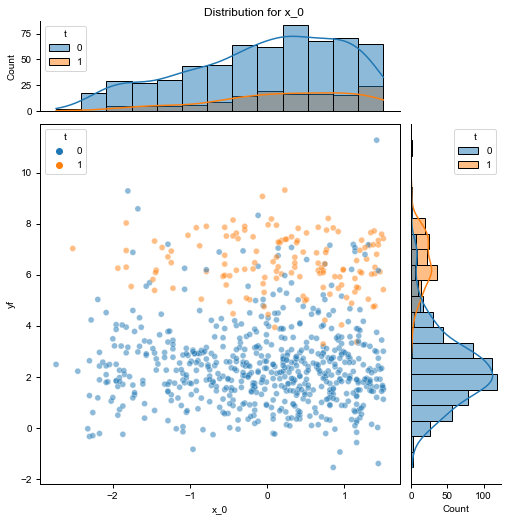

In [43]:
jointplot_maker(ihdp_df[["x_0","yf","t"]],"x_0","yf","t", debug=True).savefig(quick=True)

#### 1.2.4: Discussing the IHDP dataset

We can see that most of the X measures in this dataset are boolean 'yes/no' values (with only x values 0-5
being continuous values). This implies that we don't need to perform any scaling on these latter 19 values to keep
them in a manageable range, however, we may need to consider


### 1.3: Loading the JOBS dataset

As above, but for the JOBS dataset instead.

In [ ]:
jobs_dict: Dict[str, np.ndarray] = npz_to_dict("jobs.npz")


for k,v in jobs_dict.items():
    print(f"{k}: {v.shape}")

#### 1.3.1: Loading the X data from JOBS

In [ ]:
jobs_df_x: DataFrame = x_to_dataframe(jobs_dict['x'])

jobs_df_x.head()

In [ ]:
print(jobs_df_x.info())

jobs_df_x.describe()


In [ ]:
print(jobs_df_x.nunique())

#### 1.3.2: Loading the remaining data from JOBS

In [ ]:
jobs_df: DataFrame = add_everything_but_x_to_copy_of_dataframe(
    jobs_df_x.copy(),
    jobs_dict,
    "x"
)

jobs_df.head()

In [ ]:
print(jobs_df.info())

jobs_df.describe()

#### 1.3.3: Discussing the JOBS dataset
